In [1]:
import torch
import numpy as np
from torch import nn
import torch.utils.data
import torch.nn.functional as F
import matplotlib.pyplot as plt

## data

In [4]:
DEVICE='cuda'

def normalize(x):
    x = x.to(torch.float)
    return (x-torch.min(x)) / (torch.max(x) - torch.min(x))

import torchvision as TV
FM = TV.datasets.MNIST(root='MNIST', download=True, transform=TV.transforms.functional.to_tensor)
loader = torch.utils.data.DataLoader(FM, batch_size=36, shuffle=True, num_workers=4)

n = 60000
X = FM.train_data[:n].reshape(n, -1)
X = normalize(X)

## VAE

In [32]:
latent_dim = 20
categorical_dim = 10

def random_gumbel(shape):
    U = torch.rand(shape).to(DEVICE)
    return -torch.log(-torch.log(U))

def gumbel_softmax(logits, temperature):
    y = logits + random_gumbel(shape=logits.shape)
    return F.softmax(y / temperature, dim=-1).view(-1, latent_dim * categorical_dim)

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(784, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, latent_dim * categorical_dim), nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim * categorical_dim, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, 784), nn.Sigmoid(),
        )
        
    def encode(self, x):
        return self.encoder.forward(x)

    def decode(self, code):
        return self.decoder.forward(code)
    
    def forward(self, x, temperature):
        encoded = self.encode(x.view(-1, 784))
        encoded = encoded.view(-1, latent_dim, categorical_dim)
        sample = gumbel_softmax(encoded, temperature)
        return self.decode(sample), F.softmax(encoded, dim=-1)
    
    def __get__(self, x):
        return self.forward(x)
    
vae = VAE()
vae.to(DEVICE)
optim = torch.optim.Adam( vae.parameters(), lr=1e-3 )

In [33]:
def loss_function(recon_x, x, qy):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    log_qy = torch.log(qy + 1e-20)
    g = torch.log(torch.Tensor([1.0 / categorical_dim])).to(DEVICE)
    KLD = torch.sum(qy * (log_qy - g), dim=-1).mean()
    return BCE + KLD

loss = loss_function

In [34]:
while True:
    try:
        cumLoss = 0
        for i, (x, y) in enumerate(loader):
            x = normalize(x)
            x = x.to(DEVICE)

            optim.zero_grad()
            decoded, kld = vae.forward(x, temperature=0.5)
            L = loss(decoded, x, kld)
            L.backward()

            with torch.no_grad():
                optim.step()
                cumLoss += L

            print('\rLoss: {}'.format(cumLoss / i), end='')
        print('')
        
    except KeyboardInterrupt:
        break

Loss: 5685.5458984375
Loss: 4377.0634765625
Loss: 4017.105224609375
Loss: 3777.94189453125
Loss: 3635.83447265625
Loss: 3542.5498046875
Loss: 3475.025634765625
Loss: 3421.91455078125
Loss: 3379.272705078125
Loss: 3343.925048828125
Loss: 3319.69921875
Loss: 3292.66796875
Loss: 3279.14404296875
Loss: 3261.25341796875
Loss: 3246.279052734375
Loss: 3236.728271484375
Loss: 3231.53076171875
Loss: 3218.367431640625
Loss: 3218.0654296875
Loss: 3212.724609375
Loss: 3208.93017578125
Loss: 3207.228515625
Loss: 3192.16455078125
Loss: 3193.758056640625
Loss: 3185.052490234375
Loss: 3188.818603515625
Loss: 3195.6533203125
Loss: 3186.37646484375
Loss: 3192.263427734375
Loss: 3183.13916015625
Loss: 3184.749755859375

# Reconstruction

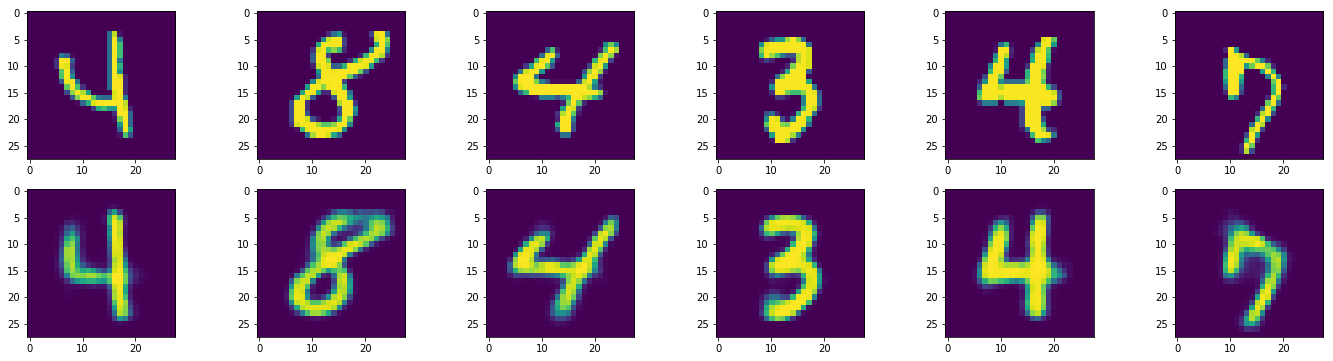

In [35]:
n = 6

randind = np.random.randint(FM.train_data.shape[0], size=(n))
X = FM.train_data[randind].to(DEVICE)
X = normalize(X)
decoded, latent = vae.forward(X, 1.)
decoded = decoded.cpu()

plt.figure(figsize=(24,6))
for ind in range(n):
    dim = int(decoded[ind].numel()**0.5)
    plt.subplot(2, n, ind+1); plt.imshow(X[ind].cpu().reshape(dim, dim).detach())
    plt.subplot(2, n, ind+n+1); plt.imshow(decoded[ind].reshape(dim, dim).detach())

# Generating

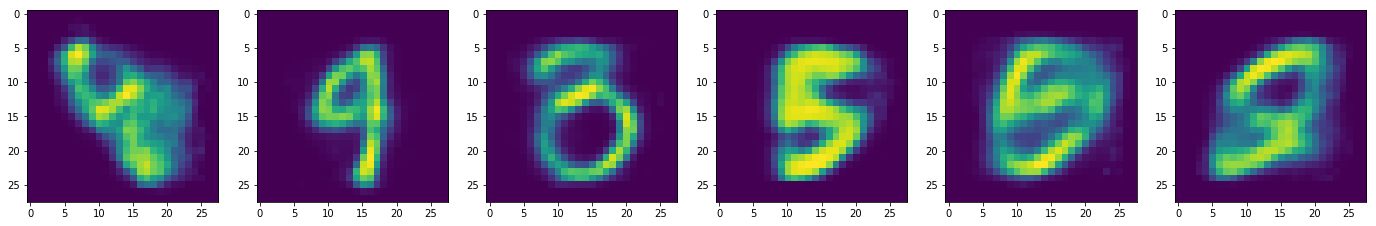

In [89]:
n = 6

random_input = torch.rand(n, latent_dim * categorical_dim, device=DEVICE)*5
X = random_input.view(-1, latent_dim, categorical_dim)
X = (X == X.max(-1)[0][:, :, None]).to(torch.float)

sample = X.view(-1, latent_dim * categorical_dim)
decoded = vae.decode(sample)
decoded = decoded.reshape(-1, 28,28).detach().cpu()

plt.figure(figsize=(24,6))
for ind in range(1, n+1):
    dim = int(decoded[ind-1].numel()**0.5)
    plt.subplot(1, n, ind); plt.imshow(decoded[ind-1].reshape(dim, dim).detach())